In [1]:
import matplotlib.pyplot as plt
import numpy as np

#import pandas as pd
import os 

import h5py
import json
import random
from datetime import date
from scipy.integrate import simpson
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

resize_transform = transforms.Resize( (256, 128) )
inverse_resize_transform = transforms.Resize( (201, 101) )

if(torch.cuda.is_available()):
    count = torch.cuda.device_count();
    print("CUDA is available and can be used by", count, "device(s).");
    curr_device =  torch.cuda.current_device();
    for i in range(count):
        curr_device_name = torch.cuda.get_device_name(i);
        print("Device",curr_device_name, ", referring to the GPU", curr_device_name, ", is in use by torch");
        
else:
    print("CUDA is unavailable");

CUDA is available and can be used by 4 device(s).
Device NVIDIA A100-SXM4-40GB , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch
Device NVIDIA A100-SXM4-40GB , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch
Device NVIDIA A100-SXM4-40GB , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch
Device NVIDIA A100-SXM4-40GB , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch


In [2]:
tracking_results_direc = '/global/cfs/cdirs/m669/riverr/2DCSR/results_lucretia_beams/' ## directory containing CSR wakefields 
vary_s_results_direc = '/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/'
beam_direc= '/global/cfs/cdirs/m669/riverr/2DCSR/lucretia_beams/' ## directory containing beams used to calculate CSR wakefields 

#Used to label data
today = str(date.today());

In [ ]:
## We really shouldn't use this, inefficient
"""
def load_step(file, n_step, directory = tracking_results_direc, emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');
    result = h5['csr_result'];
    #print(result.keys())
    nz, nx = result["Ws_grid_list"][n_step].T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = result["lambda_grid_list"][n_step].T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = result["zmin_list"][n_step]; ## minimum z coordinate
    zmax = result["zmax_list"][n_step];
    xmin = result["xmin_list"][n_step];
    xmax = result["xmax_list"][n_step];

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = result["Ws_grid_list"][n_step].T;
    Wx_grid = result["Wx_grid_list"][n_step].T;
    lambda_grid = result["lambda_grid_list"][n_step].T;

    s = np.array(result["s_at_kick_list"])[n_step];
    if emit:
        epsx = np.array(result["emit_at_kick_list"])[n_step];
        epsx_0 = np.array(result["emit_disp_free_at_kick_list"])[n_step];
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s, epsx, epsx_0 ;
    else:
        
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;
    """;

## Here we will choose the phases we exclude from training and load in the data

In [3]:
L2_phases = []
for j, file in enumerate(os.listdir(tracking_results_direc)):
    if file.startswith('result'):
        ind_0 = file.find("P2");
        ind_1 = file.find(".h");
        L2_phase = file[ind_0+3: ind_1];
        L2_phases.append(float(L2_phase));
L2_phases_sorted = sorted(L2_phases)

to_exclude_bottom = [L2_phases_sorted[i] for i in range(0,3)];
to_exclude_top = ([L2_phases_sorted[i] for i in range(-3,0)]);   

excluded_phases = [];
for phi in L2_phases:
    if(phi in to_exclude_bottom or phi in to_exclude_top):
        excluded_phases.append(phi);
    
excluded_phases;
print("Excluding phases ");
for phi in excluded_phases:
    print(phi, ",");
print(" from training")

Excluding phases 
-38.95 ,
-39.0 ,
-37.55 ,
-38.975 ,
-37.525 ,
-37.5 ,
 from training


## Loading beam + wake data in from disk

In [4]:
def load_data(data_dir, excluded = []):
    Ws_data, Wx_data, rho_data, dz_data, dx_data, s_data, phi_data = [], [], [], [], [], [], [];
    Ws_test, Wx_test, rho_test, dz_test, dx_test, s_test, phi_test = [], [], [], [], [], [], [];
    #print(data_dir)
    for j, file in enumerate(os.listdir(data_dir)):
        if file.startswith('result'):
            ind0 = file.find('P2_');
            indf = file.find('.h5')
            thisPhi2 = file[ind0 + 3: indf];
            #print(float(thisPhi2))
            test_beam =  h5py.File(data_dir + file, 'r')['csr_result'];
            if( not (float(thisPhi2)  in excluded  ) ):
                #print("Saving data for phase ", thisPhi2, " at ", file , " for training");
                
                Ws, Wx, lambda_grid, s, x_mins, x_maxs, z_mins, z_maxs = test_beam['Ws_grid_list'][:, :-1, :-1], test_beam['Wx_grid_list'][:, :-1, :-1], test_beam['lambda_grid_list'], test_beam['s_at_kick_list'], test_beam['xmin_list'], test_beam['xmax_list'], test_beam['zmin_list'], test_beam['zmax_list']
                ns = len(Ws)
                nx, nz =   Ws[0].shape;
                nx +=1; nz +=1;
                
                dx = [ (x_maxs[i]-  x_mins[i]) / nx for i in range(ns)]
                dz = [ (z_maxs[i]-  z_mins[i]) / nx for i in range(ns)]


                for i in range(ns):
                    Ws_data.append(Ws[i].transpose());
                    Wx_data.append(Wx[i].transpose());
                    rho_data.append( dx[i] * dz[i] * lambda_grid[i].transpose());
                    dz_data.append(dz[i]);
                    dx_data.append(dx[i]);
                    s_data.append(s[i]);
                    phi_data.append(thisPhi2)
                    
            else:
                Ws, Wx, lambda_grid, s, x_mins, x_maxs, z_mins, z_maxs = test_beam['Ws_grid_list'][:, :-1, :-1], test_beam['Wx_grid_list'][:, :-1, :-1], test_beam['lambda_grid_list'], test_beam['s_at_kick_list'], test_beam['xmin_list'], test_beam['xmax_list'], test_beam['zmin_list'], test_beam['zmax_list']
                print("Loading ", file, f"with {20} steps for testing");
                
                ns = len(Ws)
                nx, nz =   Ws[0].shape;
                nx +=1; nz +=1;

                dx = [ (x_maxs[i]-  x_mins[i]) / nx for i in range(ns)]
                dz = [ (z_maxs[i]-  z_mins[i]) / nx for i in range(ns)]


                for i in range(ns):
                    Ws_test.append(Ws[i].transpose());
                    Wx_test.append(Wx[i].transpose());
                    rho_test.append( dx[i] * dz[i] * lambda_grid[i].transpose());
                    dz_test.append(dz[i]);
                    dx_test.append(dx[i]);
                    s_test.append(s[i]);
                    phi_test.append(thisPhi2)
                    
        
    train_dict = {'Ws': np.array(Ws_data), 'Wx': np.array(Wx_data), 'rho' : np.array(rho_data), 'dz': np.array(dz_data), 'dx': np.array(dx_data),  's': np.array(s_data),  'phi2' : phi_data };
    test_dict = {'Ws': np.array(Ws_test), 'Wx': np.array(Wx_test), 'rho' : np.array(rho_test),  'dz': np.array(dz_test), 'dx': np.array(dx_test), 's': np.array(s_test), 'phi2' : phi_test}                                                     
    out_dict  = {'train': train_dict, 'test': test_dict};
    return out_dict;                                                                                 

In [5]:
%%time
assert -38.5 not in excluded_phases, "Nominal phase is used for normalization of the training set"
allData =  load_data(tracking_results_direc, excluded_phases)
dataDict = allData['train'];
testDict = allData['test'];
Ws_data, Wx_data, rho_data, dz_data, dx_data, s_data, phi_data = dataDict['Ws'], dataDict['Wx'], dataDict['rho'], dataDict['dz'], dataDict['dx'], dataDict['s'], dataDict['phi2']
Ws_test, Wx_test, rho_test, dz_test, dx_test, s_test, phi_test = testDict['Ws'], testDict['Wx'], testDict['rho'], testDict['dz'], testDict['dx'], testDict['s'], testDict['phi2']

print("Data successfully loaded")

Loading  result_P1_-20_P2_-38.95.h5 with 20 steps for testing
Loading  result_P1_-20_P2_-39.h5 with 20 steps for testing
Loading  result_P1_-20_P2_-37.55.h5 with 20 steps for testing
Loading  result_P1_-20_P2_-38.975.h5 with 20 steps for testing
Loading  result_P1_-20_P2_-37.525.h5 with 20 steps for testing
Loading  result_P1_-20_P2_-37.5.h5 with 20 steps for testing
Data successfully loaded
CPU times: user 331 ms, sys: 438 ms, total: 769 ms
Wall time: 4.91 s


## Compute normalization factors, based on amplitude of nominal parameters about which the data is a sequence of perturbations

In [6]:
ind = 0;
#Find where the nominal phase lives to use its amplitude as a normalization factor
for i in range(len(phi_data)):
    thisPhi = phi_data[i];
    if thisPhi == '-38.5':
        ind = i;
        break
nominal_Ws= Ws_data[ind : ind + 20]
nominal_Wx= Wx_data[ind : ind + 20]
amps_s = []
amps_x = []
for i in range(2):
    amps_s.append( abs(nominal_Ws[i]).max());
    amps_x.append( abs(nominal_Wx[i]).max());
print(f"Nominal beam has peak Ws amplitude {max(amps_s):.2e} /m");
print(f"Nominal beam has peak Wx amplitude {max(amps_x):.2e} /m");
Ws_norm = max(amps_s); Wx_norm = max(amps_x);

s_norm = np.max(s_data);
dz_norm = np.max(dz_data);
dx_norm = np.max(dx_data);

#Save somewhere safe
#asedir = 'global/homes/o/ocamacho/2DCSR_from_home/saved_networks/';
normalizations = {"Ws_norm" : float(Ws_norm), "Wx_norm" : float(Wx_norm), "s_norm" : float(s_norm), "dz_norm" : float(dz_norm), "dx_norm" : float(dx_norm) };
#CHANGE THIS ON EVERY RUN
normalizations_filename = "normalization_" + today + ".txt"

with h5py.File(normalizations_filename, 'w') as f:
    f['Ws_norm'] = Ws_norm
    f['Wx_norm'] = Wx_norm
    f['dx_norm'] = dx_norm
    f['dz_norm'] = dz_norm
    f['s_norm'] = s_norm
    
with open(normalizations_filename, 'w') as file:
        json.dump(normalizations, file)
print("Successfully saved our normalizations at ",normalizations_filename )

Nominal beam has peak Ws amplitude 5.86e+05 /m
Nominal beam has peak Wx amplitude 1.24e+04 /m
Successfully saved our normalizations at  normalization_2024-05-02.txt


## The following cell groups and shapes the training data for use in pytorch

In [7]:
#Rescale factor
fac = 100*200/(256*128);

Ws_data = torch.tensor(Ws_data)
Ws_data = fac*resize_transform(Ws_data)
Ws_data = torch.unsqueeze(Ws_data, dim=1)

Wx_data = torch.tensor(Wx_data)
Wx_data = fac*resize_transform(Wx_data)
Wx_data = torch.unsqueeze(Wx_data, dim=1)

rho_data = torch.tensor(rho_data)
rho_data = fac*resize_transform(rho_data)
rho_data = torch.unsqueeze(rho_data, dim=1)

dx_data = torch.tensor(dx_data)
dx_data = torch.unsqueeze(dx_data, dim=1)
dz_data = torch.tensor(dz_data)
dz_data = torch.unsqueeze(dz_data, dim=1)
s_data = torch.tensor(s_data)
s_data = torch.unsqueeze(s_data, dim=1)

#Ws_norm = torch.max(Ws_data)
#Wx_norm = torch.max(Wx_data)


Ws_data /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_data /= Wx_norm ## normalize to maximum Wx in dataset
s_data /= s_norm ## normalize to maximum s in dataset 
dz_data /= dz_norm ## normalize dz to maximum dz in dataset 
dx_data /= dx_norm


Ws_data = Ws_data.to(torch.float32)
Wx_data = Wx_data.to(torch.float32)
rho_data = rho_data.to(torch.float32)
s_data = s_data.to(torch.float32)
dz_data = dz_data.to(torch.float32)
dx_data = dx_data.to(torch.float32)



## two-dimensional W array 
W_data = torch.cat((Ws_data, Wx_data), dim=1);
scalar_data = torch.cat((s_data,dx_data,dz_data), dim=1);


print("Training data loaded and processed")

Training data loaded and processed


In [ ]:
## Ditto for the testing data

In [8]:
fac = 100*200/(256*128);

Ws_test = torch.tensor(Ws_test)
Ws_test = fac*resize_transform(Ws_test)
Ws_test = torch.unsqueeze(Ws_test, dim=1)

Wx_test = torch.tensor(Wx_test)
Wx_test = fac*resize_transform(Wx_test)
Wx_test = torch.unsqueeze(Wx_test, dim=1)

rho_test = torch.tensor(rho_test)
rho_test = fac*resize_transform(rho_test)
rho_test = torch.unsqueeze(rho_test, dim=1)

dx_test = torch.tensor(dx_test)
dx_test = torch.unsqueeze(dx_test, dim=1)

dz_test = torch.tensor(dz_test)
dz_test = torch.unsqueeze(dz_test, dim=1)

s_test = torch.tensor(s_test)
s_test = torch.unsqueeze(s_test, dim=1)



Ws_test /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_test /= Wx_norm ## normalize to maximum Wx in dataset
s_test /= s_norm ## normalize to maximum s in dataset 
dz_test /= dz_norm ## normalize dz to maximum dz in dataset 
dx_test /= dx_norm



Ws_test = Ws_test.to(torch.float32)
Wx_test = Wx_test.to(torch.float32)
rho_test = rho_test.to(torch.float32)
s_test = s_test.to(torch.float32)
dz_test = dz_test.to(torch.float32)
dx_test = dx_test.to(torch.float32)



## two-dimensional W array 
W_test = torch.cat((Ws_test, Wx_test), dim=1);
scalar_test = torch.cat((s_test,dx_test,dz_test), dim=1);


print("Test data loaded and processed")

Test data loaded and processed


In [ ]:
# OLD method, very slow! Kept for posterity


"""
ns = np.arange(1) # 20 steps per simulation 

for j, file in enumerate(os.listdir(tracking_results_direc)):
    if file.startswith('result'):
        ind_0 = file.find("P2");
        ind_1 = file.find(".h");
        L2_phase = float(file[ind_0+3: ind_1]);
        test_beam =  h5py.File(file, 'r');
        if(L2_phase in excluded_phases):
            print("Not training on ", L2_phase);
            continue;
        else:
            pass;
            #print(f"Loading {L2_phase}");
        for i, n in enumerate(ns):
            xv, zv, Ws, Wx, rho, s = load_step(file, n)
            Ws = Ws[:-1,:-1]
            Wx = Wx[:-1,:-1]
            rho = rho[:]

            dx = np.mean(np.diff(xv))
            dz = np.mean(np.diff(zv))
            #print(len(xv), len(zv) )
            if (i == 0) & (j == 0):
                Ws_data = [Ws]
                Wx_data = [Wx]
                rho_data = [rho*dx*dz] ## note: rho is normalized to have sum of unity 
                dx_data = [dx]
                dz_data = [dz]
                s_data = [s]
            else:
                Ws_data = np.concatenate(([Ws], Ws_data))
                Wx_data = np.concatenate(([Wx], Wx_data))
                rho_data = np.concatenate(([rho*dx*dz], rho_data)) ## note: rho is normalized to have sum of unity 
                dx_data = np.concatenate(([dx], dx_data))
                dz_data = np.concatenate(([dz], dz_data))
                s_data = np.concatenate(([s], s_data))
                
print("Done loading in data");


### NOTE: resize_transform does not preserve the sum of the arrays over the grid. Thus we multiply by (100*200/(256*128))                
## when we resize back later on, we should multiply by the inverse factor 
fac = 100*200/(256*128);

Ws_data = torch.tensor(Ws_data)
Ws_data = fac*resize_transform(Ws_data)
Ws_data = torch.unsqueeze(Ws_data, dim=1)

Wx_data = torch.tensor(Wx_data)
Wx_data = fac*resize_transform(Wx_data)
Wx_data = torch.unsqueeze(Wx_data, dim=1)

rho_data = torch.tensor(rho_data)
rho_data = fac*resize_transform(rho_data)
rho_data = torch.unsqueeze(rho_data, dim=1)

dx_data = torch.tensor(dx_data)
dx_data = torch.unsqueeze(dx_data, dim=1)
dz_data = torch.tensor(dz_data)
dz_data = torch.unsqueeze(dz_data, dim=1)
s_data = torch.tensor(s_data)
s_data = torch.unsqueeze(s_data, dim=1)

Ws_norm = torch.max(Ws_data)
Wx_norm = torch.max(Wx_data)
s_norm = torch.max(s_data)
dz_norm = torch.max(dz_data)
dx_norm = torch.max(dx_data)

Ws_data /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_data /= Wx_norm ## normalize to maximum Wx in dataset
s_data /= s_norm ## normalize to maximum s in dataset 
dz_data /= dz_norm ## normalize dz to maximum dz in dataset 
dx_data /= dx_norm


#Save somewhere safe
#asedir = 'global/homes/o/ocamacho/2DCSR_from_home/saved_networks/';
normalizations = {"Ws_norm" : float(Ws_norm), "Wx_norm" : float(Wx_norm), "s_norm" : float(s_norm), "dz_norm" : float(dz_norm), "dx_norm" : float(dx_norm) };
#CHANGE THIS ON EVERY RUN
normalizations_filename = "normalization_04-30-24_750_epochs.txt"

with open(normalizations_filename, 'w') as file:
        json.dump(normalizations, file)
print("Successfully saved our normalizations")



Ws_data = Ws_data.to(torch.float32)
Wx_data = Wx_data.to(torch.float32)
rho_data = rho_data.to(torch.float32)
s_data = s_data.to(torch.float32)
dz_data = dz_data.to(torch.float32)
dx_data = dx_data.to(torch.float32)



## two-dimensional W array 
W_data = torch.cat((Ws_data, Wx_data), dim=1);
scalar_data = torch.cat((s_data,dx_data,dz_data), dim=1);
""";


## Currently I have all of the non-test data in rho_data, Ws_data, Wx_data, dx_data, dz_data, s_data. 
## Now I need to split into training and validation

In [9]:
# Split up into training, validation, and testing batches
n_total = Ws_data.shape[0]
print(f"Starting with {n_total} pieces of data");
train_frac = 0.85 #approximate ercentage of data to be used for training
val_frac = 0.15;#for validation
assert train_frac + val_frac == 1.0

n_train = int(train_frac * n_total); #Training set size
train_idx = random.sample(range(n_total), n_train)
print(len(train_idx), "training examples");


remaining_idx = [i for i in range(n_total) if i not in train_idx] # remaining indices available
n_remaining = len(remaining_idx);

n_val = n_remaining
val_idx  = [ind for ind in remaining_idx];
assert n_val == len(val_idx)
print(len(val_idx), "validation examples");


W_train = W_data[train_idx];
W_val = W_data[val_idx];



rho_train = rho_data[train_idx];
rho_val = rho_data[val_idx];

scalar_train = scalar_data[train_idx];
scalar_val = scalar_data[val_idx];


Starting with 1100 pieces of data
935 training examples
165 validation examples


In [10]:
#Make sure the sets we created are pairwise disjoint!
train_idx_set = set(); val_idx_set = set(); 
for entry in val_idx:
    val_idx_set.add(entry);
pairwise_disjoint = train_idx_set.intersection(val_idx_set)  == set() 
assert pairwise_disjoint
print("Partition is valid, continue safely")

Partition is valid, continue safely


In [11]:
#Save somewhere safe
data_partition = {"train_idx": train_idx, "val_idx": val_idx, 'exluded_phases': excluded_phases};
data_partition_filename = "partition_" + today + ".txt"


with open(data_partition_filename, 'w') as file:
        json.dump(data_partition, file)
print("Successfully saved our partition at ", data_partition_filename)

Successfully saved our partition at  partition_2024-05-02.txt


## We will want to look at the variation in the training set

In [12]:
avgRho = np.array( sum([rho for rho in rho_train]) )[0,:,:];
# marginals
x = np.linspace(0, 127, 128); z = np.linspace(0, 255, 256);
lambda_z = simpson(avgRho, x, axis=1) #([sum(avgRho[:,i]) for i in range(128)])
lambda_x = simpson(avgRho, z, axis=0) #([sum(avgRho[i,:]) for i in range(256)])

Ensemble averaged beam


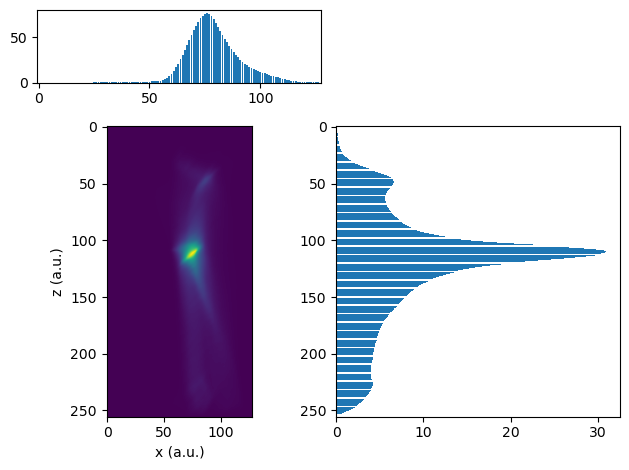

In [13]:

gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1,4]);

ax_fz = plt.subplot(gs[1,0])
ax_fx = plt.subplot(gs[0,0], sharex=ax_fz)
ax_fy = plt.subplot(gs[1,1], sharey=ax_fz)

ax_fz.imshow(avgRho )
ax_fx.bar(x, lambda_x)
ax_fy.barh(z, lambda_z)
ax_fz.set_xlabel("x (a.u.)")
ax_fz.set_ylabel("z (a.u.)")
plt.tight_layout();
print("Ensemble averaged beam")
plt.savefig(today+ "_ensemble_avg_beam.png");

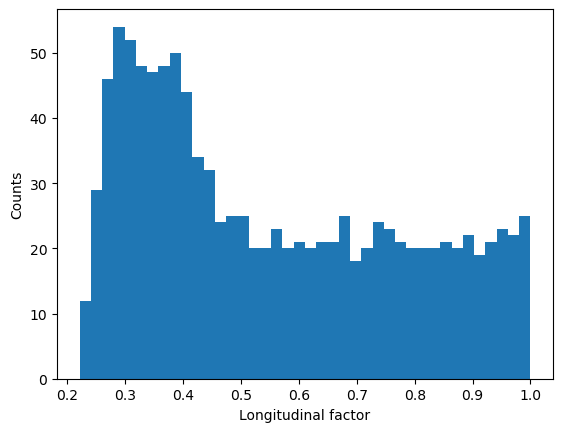

In [14]:
plt.hist([dz[0] for dz in dz_data], 40);
plt.xlabel("Longitudinal factor")
plt.ylabel("Counts")
plt.savefig(today + "_dz_variability.png")

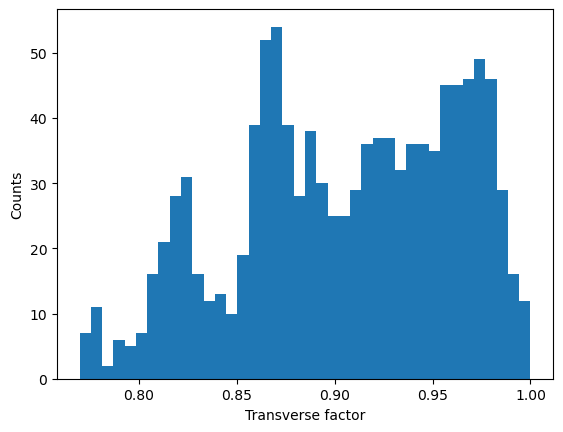

In [15]:
plt.hist([dx[0] for dx in dx_data], 40)
plt.xlabel("Transverse factor")
plt.ylabel("Counts")
plt.savefig(today + "_dx_variability.png")

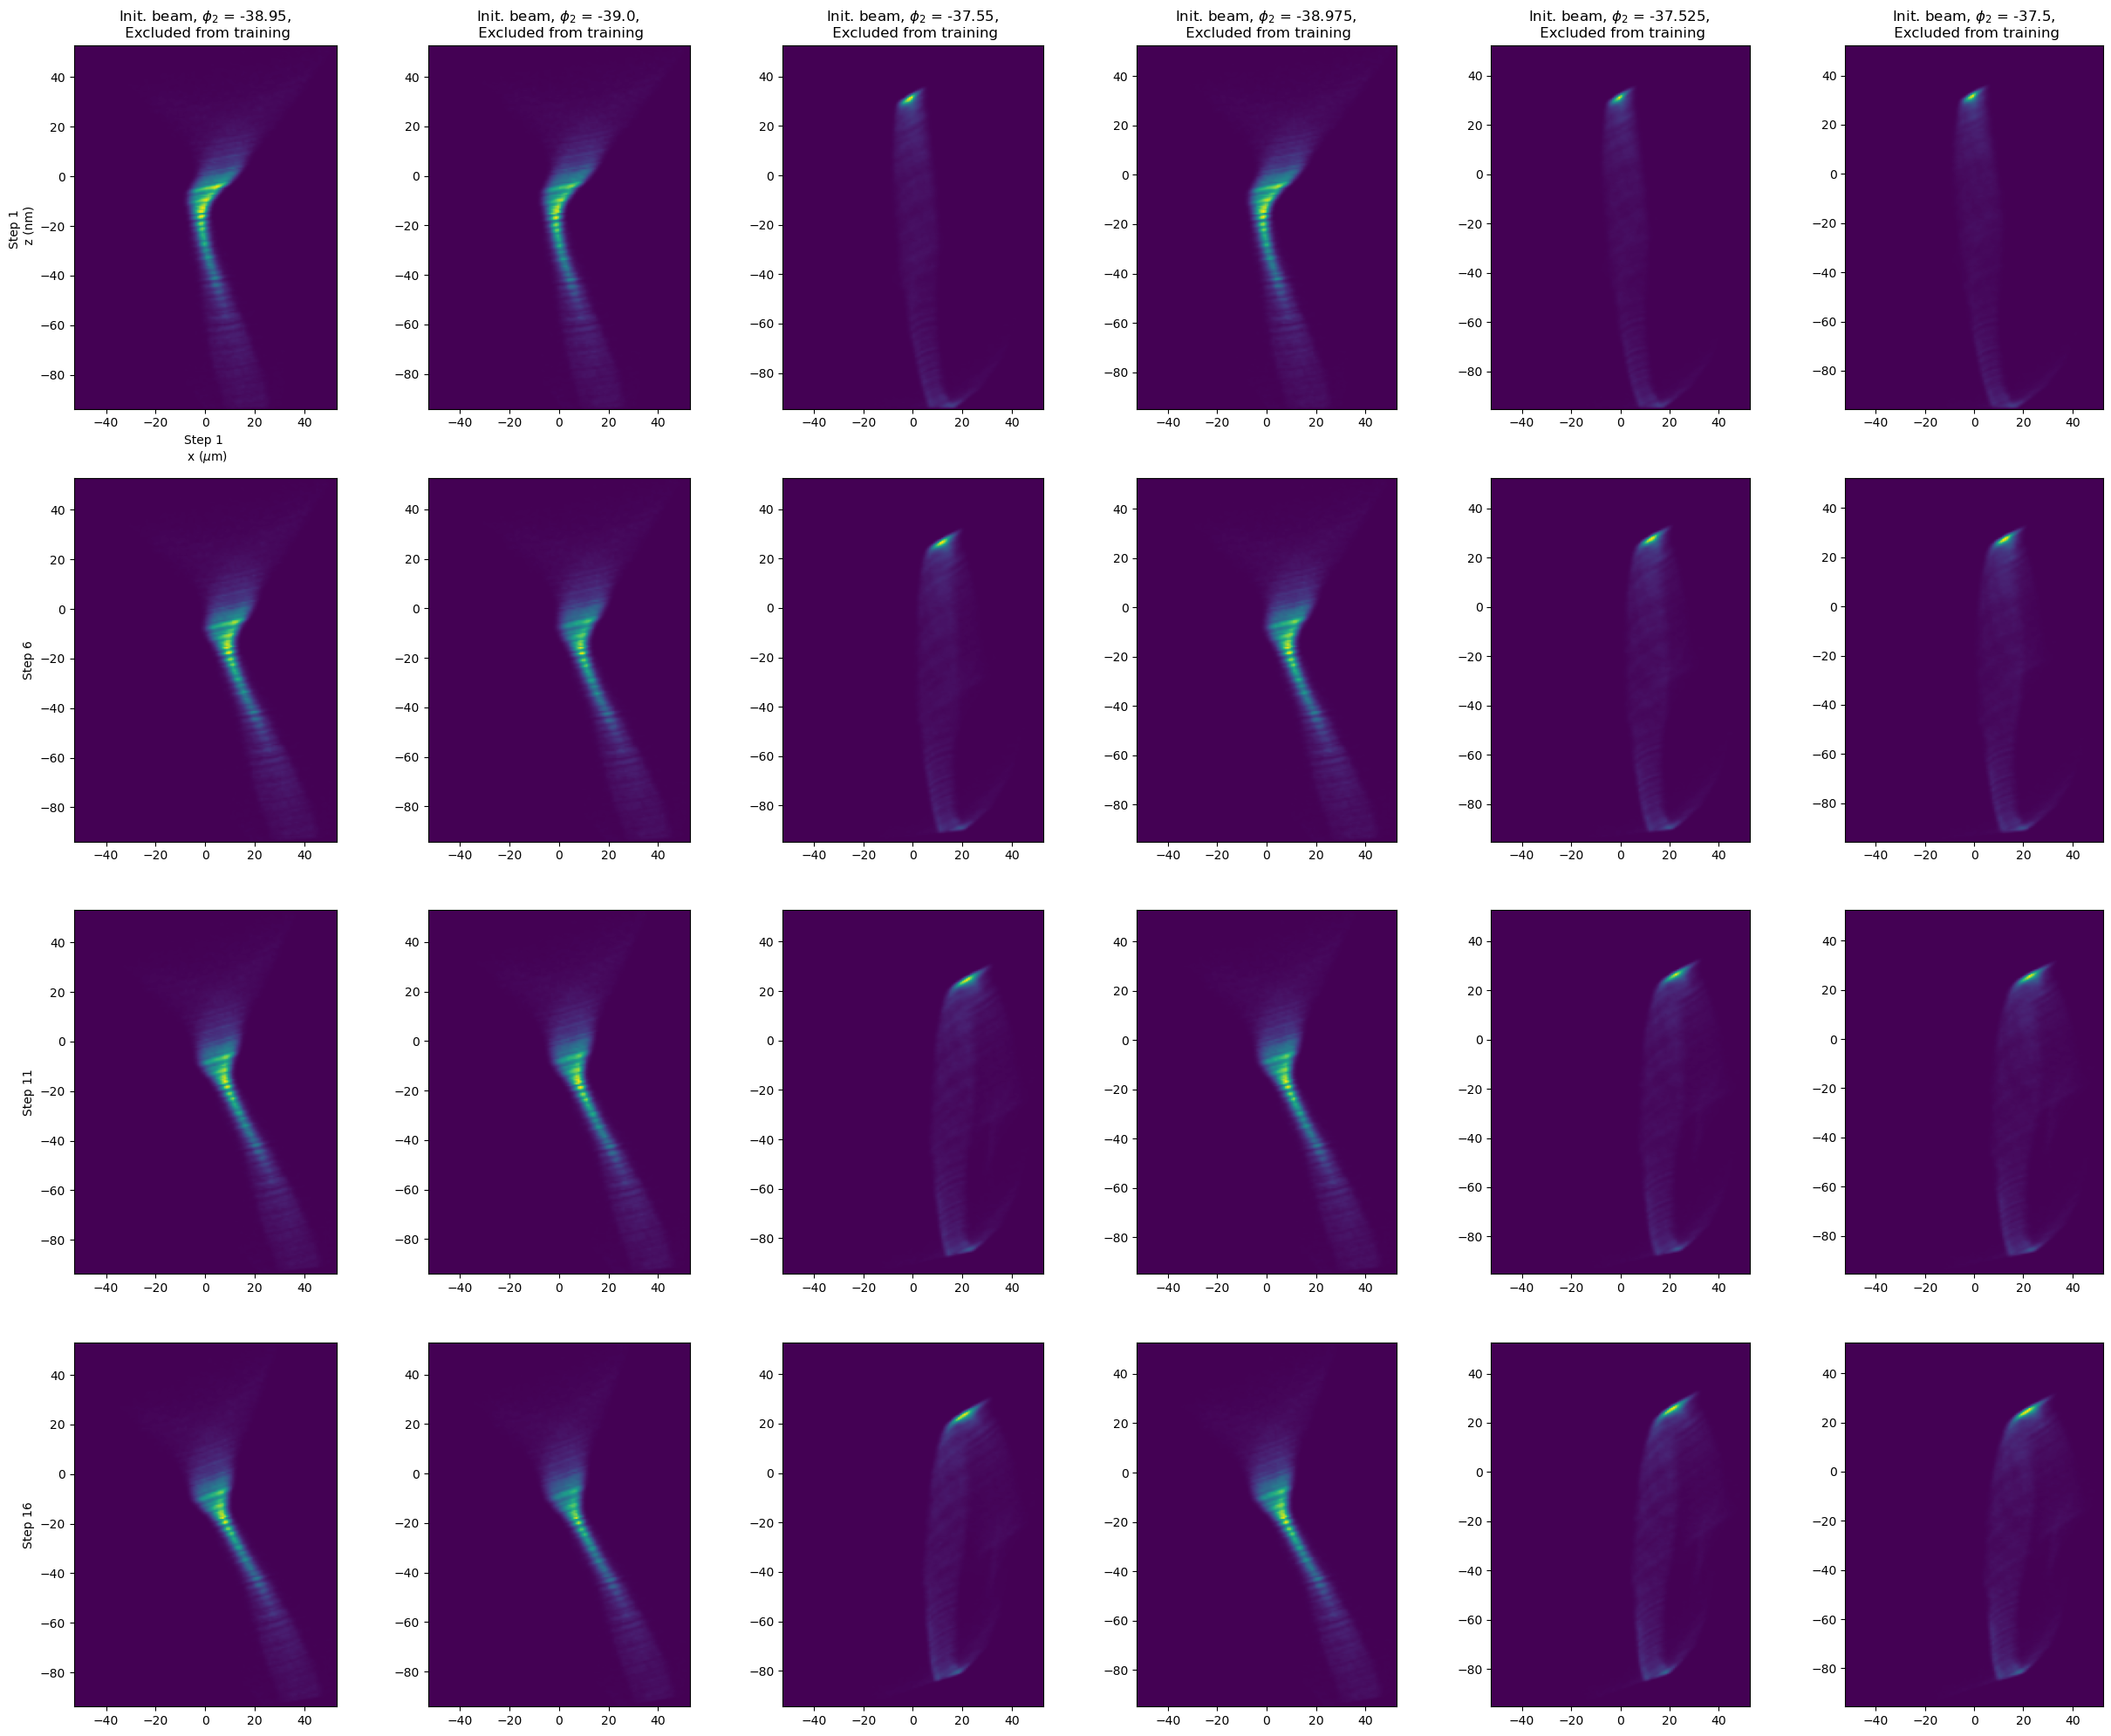

In [16]:
fig, ax = plt.subplots(4, len(excluded_phases), figsize = (25, 20) )
for i in range(len(excluded_phases)):
    ax[0][i].set_title(f"Init. beam, $\phi_2$ = {excluded_phases[i]}, \n Excluded from training");
    step = 5;
    for j in range(4):
        #Physical unit ranges
        xMin = -128*dx_data[i][0]/2;
        xMax = -xMin;
        zMin = -256*dz_data[i][0]/2;
        zMax = -xMin

        ax[j][i].imshow(rho_test[i*20 + step*j][ 0, :, :], extent=[xMin,xMax,  zMin,zMax])   ;
        thisPhi = phi_test[20*i]
        ax[j][0].set_ylabel(f"Step { (step*j + 1) }");
ax[0][0].set_ylabel(f"Step {1} \n z (nm)");
ax[0][0].set_xlabel(f"Step {1} \n x ($\mu$m)");
fig.tight_layout()
plt.savefig(today+"_excluded_profiles.png")

## Define the CSR2D pytorch module

In [17]:
class CSR2D(nn.Module):
    def __init__(self):
        super(CSR2D, self).__init__()

        encoding_dim = 16 # length of 1D beam density image representation
        
        num_conv = 5 # number of convolutional layers in encoder
        nfilters = 32 # number of "matrices" in a single convolutional layer 
        kernel_sizes = (3, 7) # each size is the size of one side of the convolution matrix, we are applying two matrices here 
        pool_size = 2 # factor by which we reduce the image size on each conv layer 
        activation = nn.ReLU() # activation function for the conv layers
        
        encoder_layers = []
        
        for i in range(num_conv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0):
                    encoder_layers.append(nn.Conv2d(1, nfilters, kernel_size, padding=kernel_size//2))
                else:
                    encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding=kernel_size//2))
                encoder_layers.append(nn.BatchNorm2d(nfilters))
                encoder_layers.append(activation)
            #encoder_layers.append(nn.BatchNorm2d(nfilters))
            encoder_layers.append(nn.MaxPool2d(pool_size))
        
        encoder_layers.append(nn.Flatten())
        encoder_layers.append(nn.Linear(int(nfilters * 256/2**num_conv * 128/2**num_conv), encoding_dim))
        encoder_layers.append(activation)
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        num_dense = 2 # number of dense layers before the resizing dense layer  
        small_dim_power2 = 4 # size of image output from dense network is 2**(this) x 2**(this+1)
        num_units = 200 # number of nodes in intermediate dense layers 
        activation = nn.ReLU()
        
        dense_layers = []
        
        dense_layers.append(nn.Linear(encoding_dim + 3, num_units)) ## encoding_dim + number of scalar parameters 
        dense_layers.append(activation)
        
        for _ in range(num_dense - 1):
            dense_layers.append(nn.Linear(num_units, num_units))
            dense_layers.append(activation)
        
        dense_layers.append(nn.Linear(num_units, 2**(2*small_dim_power2+1)))
        dense_layers.append(activation)
        dense_layers.append(nn.Unflatten(1, (1,2*2**small_dim_power2, 2**small_dim_power2) )   );

        self.intermediate = nn.Sequential(*dense_layers)
        
        decoder_layers = []
        num_deconv = 7 - small_dim_power2
        
        nfilters = 32
        kernel_sizes = [3, 7]
        pool_size = 2
        activation = nn.ReLU()
        
        for i in range(num_deconv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0): 
                    decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                else:
                    decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                decoder_layers.append(nn.BatchNorm2d(nfilters))
                decoder_layers.append(activation)
            #decoder_layers.append(nn.BatchNorm2d(nfilters))
            decoder_layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
        
        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size=1, padding=0)) # linear activation is necessary if our network needs to give negative numbers
        
        self.decoder = nn.Sequential(*decoder_layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, img_inputs):
        scalar_inputs = img_inputs[1]
        img_inputs = img_inputs[0]
        encoded_flattened = self.encoder(img_inputs)
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        afterNN = self.intermediate(concatenated)
        decoded = self.decoder(afterNN) # Reshape to match the input size of decoder
        return decoded

In [21]:
training_dataset = TensorDataset(rho_train, scalar_train, W_train)
training_dataloader = DataLoader(training_dataset, batch_size= 64, shuffle=True)#.cuda()

## Train model on GPU

In [22]:
curr_device = torch.device("cuda:0")
csr2d_model = CSR2D() # the model now lives on the GPU 
"""#TODO: Put model on multiple GPUs!
csr2d_model = csr2d_model #Model(input_size, output_size)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    csr2d_model = nn.DataParallel(csr2d_model)
"""
csr2d_model.to(curr_device);

In [23]:
#csr2d_model.load_state_dict(torch.load('good_state_04-22-2024'))

In [37]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(csr2d_model.parameters(), lr=3e-3);

from torch.optim.lr_scheduler import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.50, patience=40, min_lr=1e-6)
reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=25, min_lr=1e-6)

In [38]:
%%time

# Training loop
num_epochs = 367;
epoch_losses = np.zeros(num_epochs);
val_losses = np.zeros(num_epochs);
for epoch in range(num_epochs):
    csr2d_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for rho_input, scalar_input, W_input in training_dataloader:
        rho_input, scalar_input, W_input = rho_input.to(curr_device), scalar_input.to(curr_device), W_input.to(curr_device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = csr2d_model([rho_input, scalar_input])
        loss = criterion(outputs, W_input)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * rho_input.size(0)
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(training_dataloader.dataset)
    epoch_losses[epoch] = epoch_loss 
    
    csr2d_model.eval()
    with torch.no_grad():
        val_result = csr2d_model([rho_val.to(curr_device), scalar_val.to(curr_device)])
        val_loss = criterion(val_result, W_val.to(curr_device))
        val_losses[epoch] = val_loss
    
    if(not (epoch%10) ):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]}')
    
    reduce_lr.step(val_loss);

Epoch [1/367], Loss: 0.0092, Val Loss: 0.0122, LR: 0.000168940544128418
Epoch [11/367], Loss: 0.0083, Val Loss: 0.0088, LR: 0.000168940544128418
Epoch [21/367], Loss: 0.0088, Val Loss: 0.0151, LR: 0.000168940544128418
Epoch [31/367], Loss: 0.0086, Val Loss: 0.0093, LR: 0.000168940544128418
Epoch [41/367], Loss: 0.0086, Val Loss: 0.0103, LR: 0.000168940544128418
Epoch [51/367], Loss: 0.0085, Val Loss: 0.0151, LR: 0.000168940544128418
Epoch [61/367], Loss: 0.0086, Val Loss: 0.0147, LR: 0.00012670540809631348
Epoch [71/367], Loss: 0.0082, Val Loss: 0.0098, LR: 0.00012670540809631348
Epoch [81/367], Loss: 0.0083, Val Loss: 0.0092, LR: 0.00012670540809631348
Epoch [91/367], Loss: 0.0083, Val Loss: 0.0100, LR: 0.00012670540809631348
Epoch [101/367], Loss: 0.0080, Val Loss: 0.0094, LR: 9.502905607223511e-05
Epoch [111/367], Loss: 0.0081, Val Loss: 0.0082, LR: 9.502905607223511e-05
Epoch [121/367], Loss: 0.0080, Val Loss: 0.0085, LR: 9.502905607223511e-05
Epoch [131/367], Loss: 0.0080, Val Los

## Take a look at the learning curve

In [45]:
val_loss_arr = np.append(vL[0:508], val_losses);

epoch_loss_arr = np.append(tL[0:508], epoch_losses);

In [48]:
len(epoch_loss_arr)

875

0.0

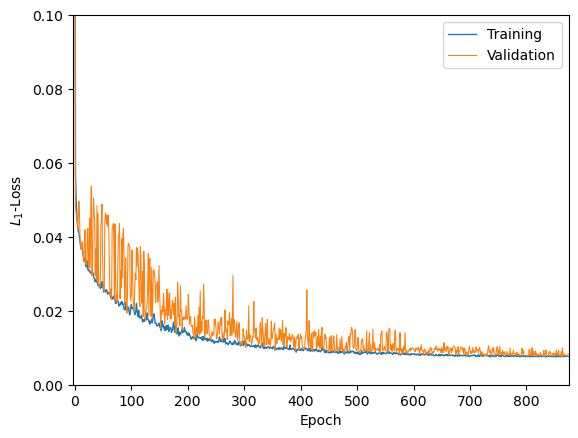

In [51]:
plt.plot(epoch_loss_arr, label = "Training", linewidth = 1)
#plt.scatter(range(len(epoch_losses)), epoch_losses, label = "Training", s = 1)
plt.ylim(0, 0.10)
plt.xlim(-4, len(val_loss_arr))
plt.plot(val_loss_arr, label = "Validation", linewidth = 3/4)
#plt.scatter(range(len(val_losses)), val_losses, label = "Validation", s = 1)
plt.xlabel("Epoch")
plt.ylabel(r"$L_1$-Loss")
plt.legend();
plt.savefig("loss_plot_" + today + ".png")

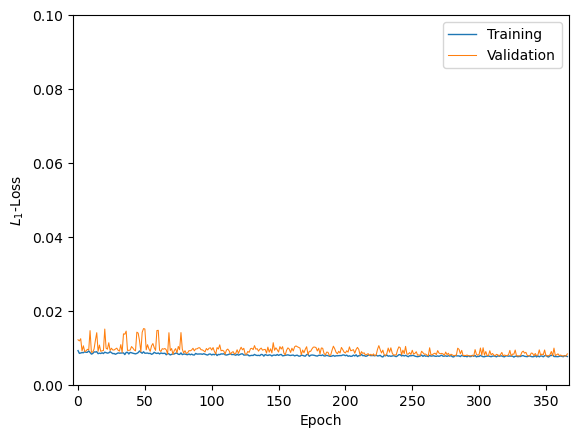

In [40]:
plt.plot(epoch_losses, label = "Training", linewidth = 1)
#plt.scatter(range(len(epoch_losses)), epoch_losses, label = "Training", s = 1)
plt.ylim(0, 0.10)
plt.xlim(-4, len(val_losses))
plt.plot(val_losses, label = "Validation", linewidth = 3/4)
#plt.scatter(range(len(val_losses)), val_losses, label = "Validation", s = 1)
plt.xlabel("Epoch")
plt.ylabel(r"$L_1$-Loss")
plt.legend();

In [56]:
csr2d_model.eval()
result_val = csr2d_model([rho_val.to(curr_device), scalar_val.to(curr_device)])

Max Ws amplitude is 1.0966671705245972
Max Wx amplitude is 0.402815043926239
L_1-error is 0.792 pct
L_2-error is 1.615 pct


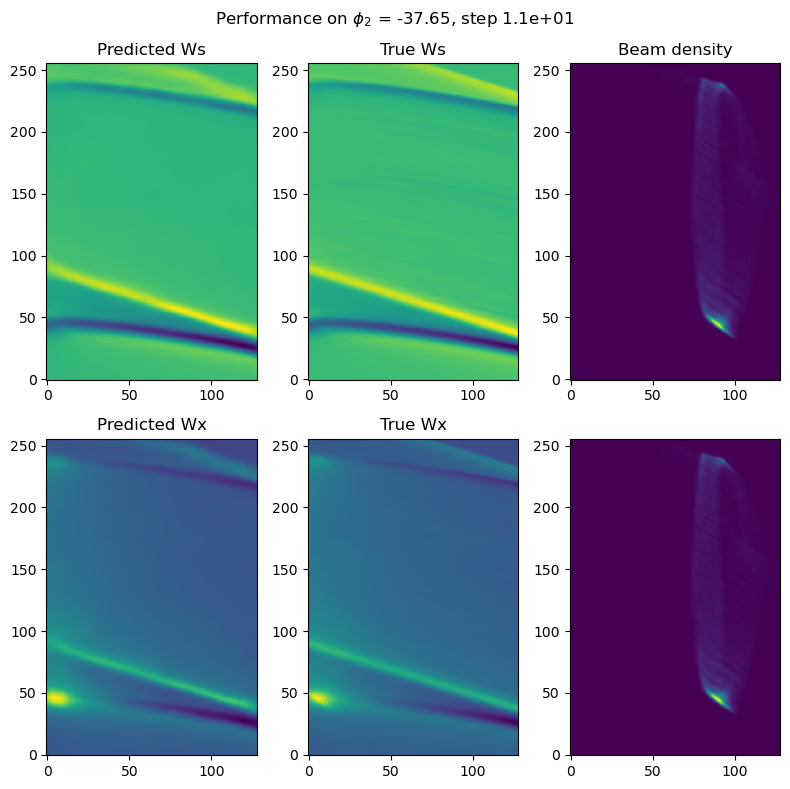

In [266]:
i = 120

fig, ax = plt.subplots(2,3, figsize=(8, 8))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_val[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_val[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')

ax[0,1].imshow(W_val[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_val[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')
ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')

ax[0,2].imshow(rho_val[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[1,2].imshow(rho_val[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[0,2].set_title("Beam density")

phi2 = phi_data[val_idx[i]];
s = s_data[val_idx[i]][0];
fig.suptitle(f"Performance on $\phi_2$ = {phi2}, step {s*20 :.1e}", fontsize=12)
fig.tight_layout()

err1 =  criterion(result_val[i].cpu(), W_val[i]).cpu().detach().numpy() ;
err2 =  np.sqrt( (criterion2(result_val[i].cpu(), W_val[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( result_val[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( result_val[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {100*err1/reff_amp_s:.3f} pct")
print(f"L_2-error is {100*err2/reff_amp_s:.3f} pct")

## Now we construct the data for the test set

In [98]:
csr2d_model.eval();
result_test = csr2d_model([rho_test.to(curr_device), scalar_test.to(curr_device)]);

Max Ws amplitude is 1.0572123527526855
Max Wx amplitude is 0.4213525354862213
L_1-error is 11.262 pct
L_2-error is 2.885 pct


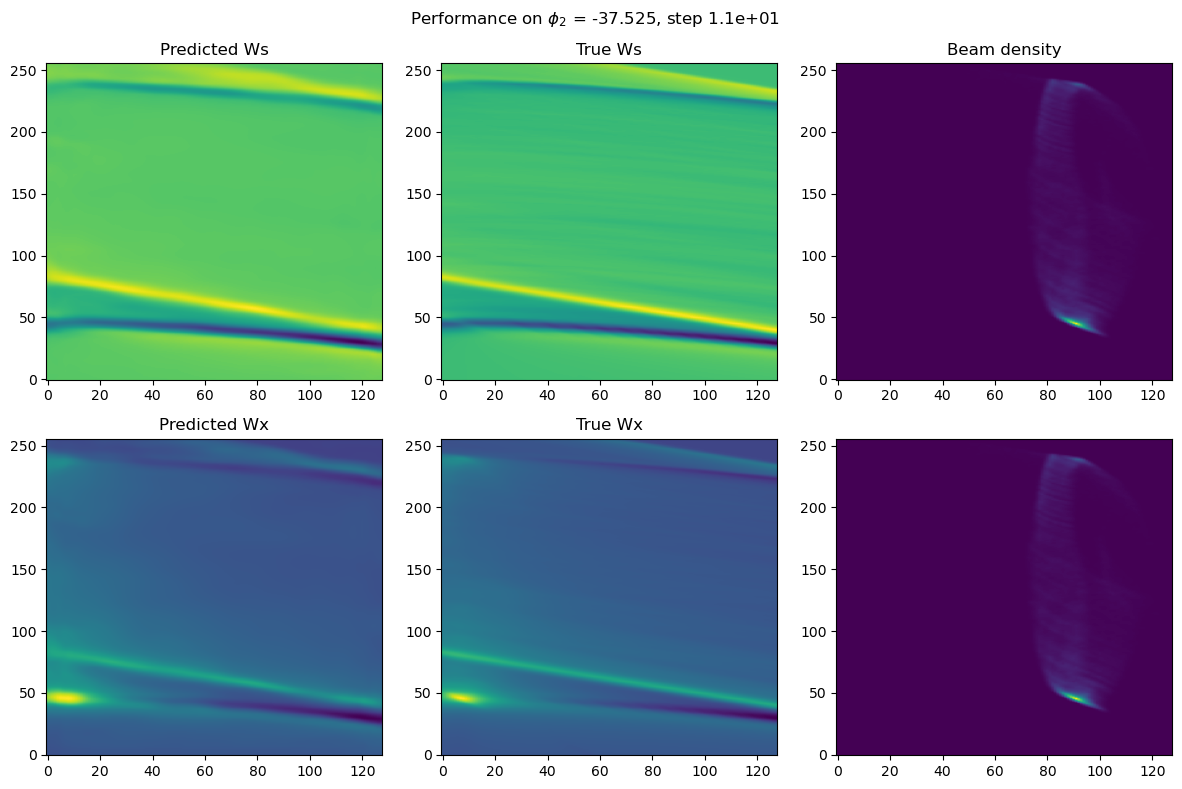

In [163]:
i = 90

fig, ax = plt.subplots(2,3,figsize=(12, 8))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_test[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')

ax[0,1].imshow(W_test[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_test[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')
ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')


ax[0,2].imshow(rho_test[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[1,2].imshow(rho_test[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[0,2].set_title("Beam density")

phi2 = phi_test[i];
s = s_data[i][0];
fig.suptitle(f"Performance on $\phi_2$ = {phi2}, step {s*20 :.1e}", fontsize=12)


fig.tight_layout()

err1 =  np.sqrt( (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( W_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( W_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {100*err1/reff_amp_s:.3f} pct")
print(f"L_2-error is {100*err2/reff_amp_s:.3f} pct")

MSELoss()

## Now we evaluate the performance over the distribution

In [207]:
test_performance = np.array([  (criterion2(result_test[i].cpu(), W_val[i]).cpu().detach().numpy() )**0.50 for i in range(len(result_test)) ]);

test_ref_amps = np.array([ np.max( np.abs( result_test[i,0].cpu().detach().numpy() ) ) + np.max( np.abs( result_test[i,1].cpu().detach().numpy() ) ) for i in range(len(result_test))]);

test_rel_performance = np.array( [ test_performance[i]/(test_ref_amps[i]) for i in range(len(test_performance))] );

In [208]:
avg_test_performance = np.mean(test_performance);
std_test_performance = np.mean(test_performance);
norm_test_performance = (test_performance - avg_test_performance)/std_test_performance;

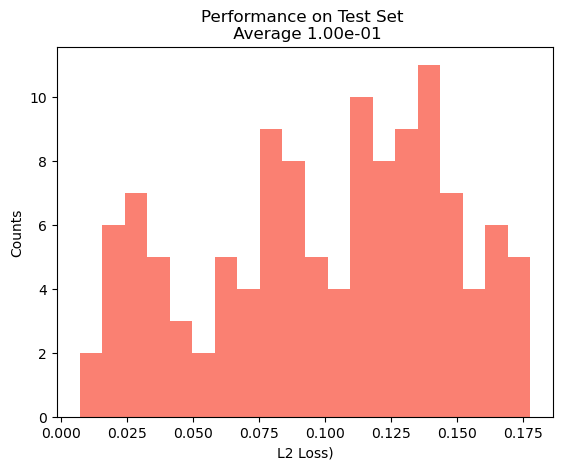

In [246]:
plt.hist(test_performance, 20, color = 'salmon');
plt.xlabel("L2 Loss)");
plt.ylabel("Counts");
plt.title(f'Performance on Test Set \n Average {avg_test_performance :.2e}');

## The best performers

In [247]:
ace_idx = np.where(test_performance < 0.075)[0];
ace_idx;
print(f"There are {len(ace_idx)} test cases on which performance was better than average")

There are 34 test cases on which performance was better than average


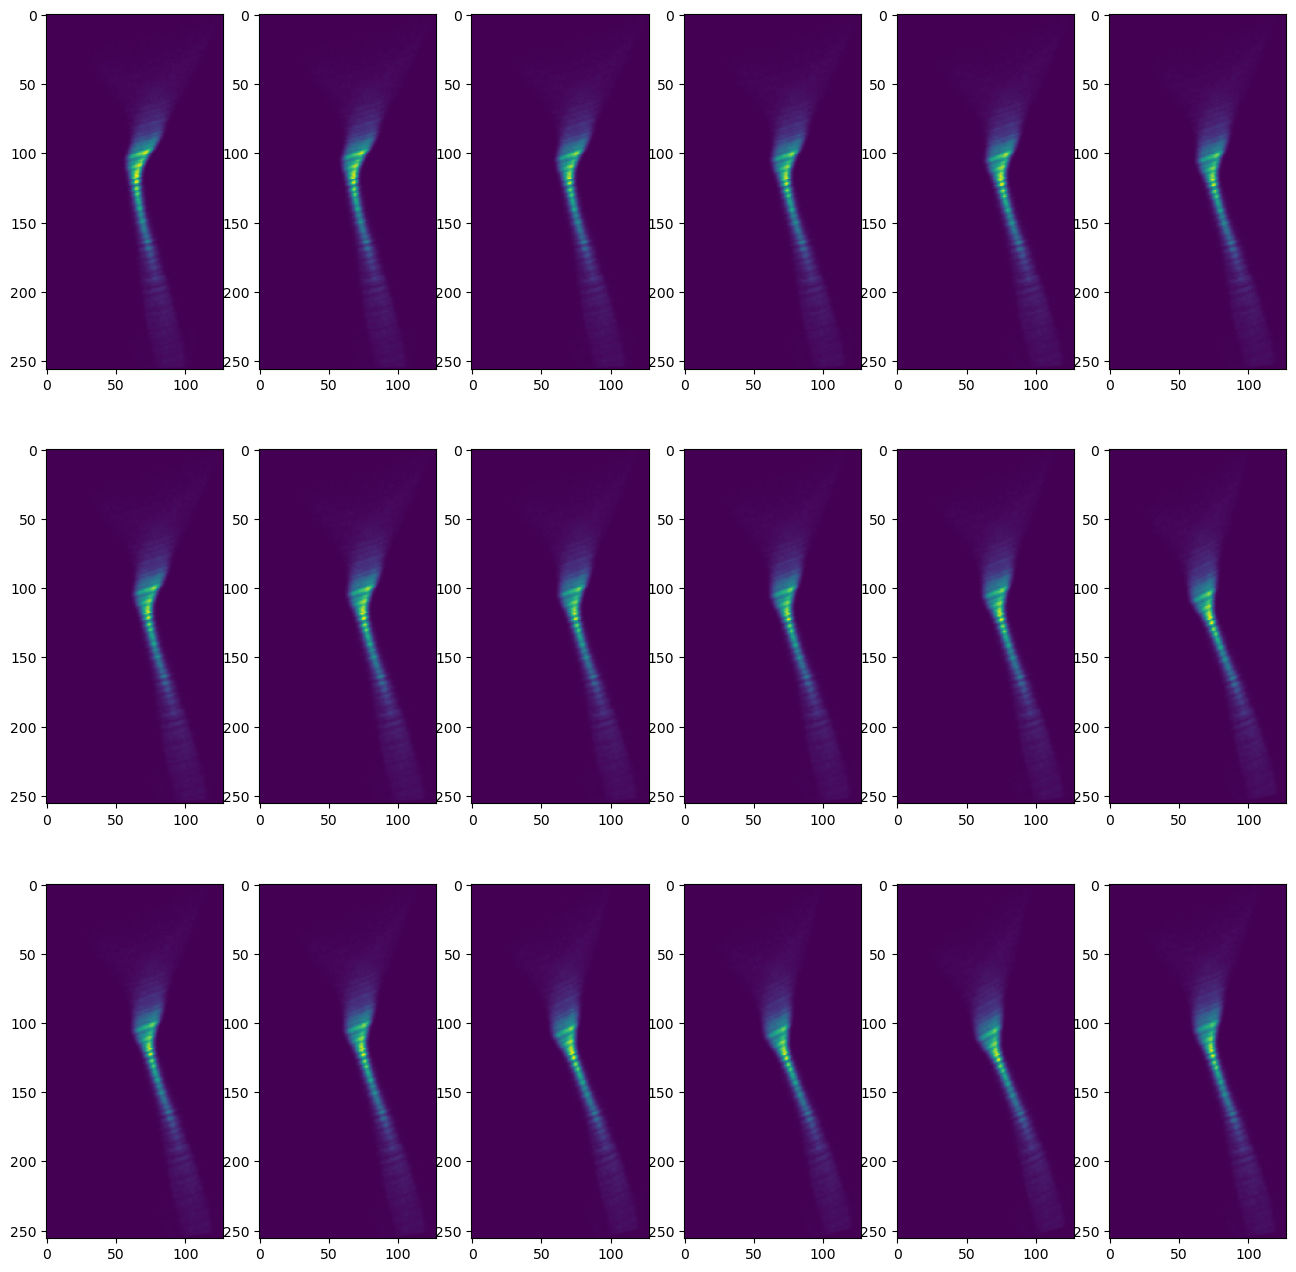

In [248]:
rho_aces = [rho_test[i] for i in ace_idx]

fig, ax = plt.subplots(3,6, figsize = (16, 16))

for i in range(3):
    for j in range(6):
        rho = rho_aces[3*i + j]
        ax[i][j].imshow(rho[0,:,:])

Max Ws amplitude is 0.3364328145980835
Max Wx amplitude is 0.2607300877571106
L_1-error is 27.902 pct
L_2-error is 5.578 pct


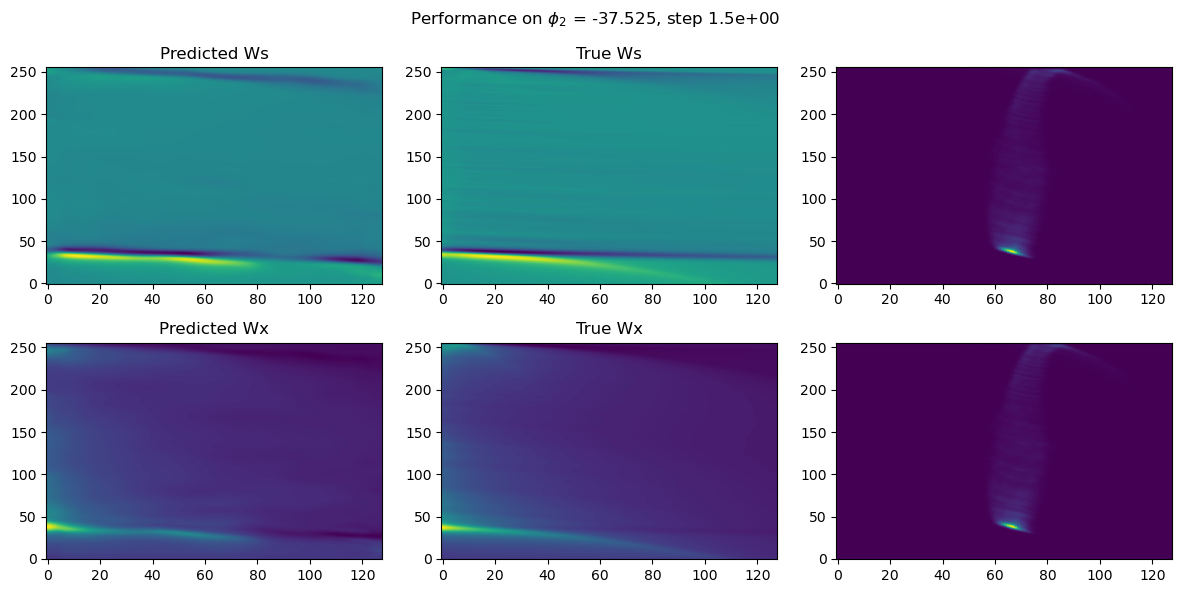

In [265]:
i = ace_idx[-1]
fig, ax = plt.subplots(2,3,figsize=(12,6))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_test[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')


ax[0,1].imshow(W_test[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_test[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')

ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')

ax[0,2].imshow(rho_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,2].imshow(rho_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')

phi2 = phi_test[i];
s = s_data[i][0];
fig.suptitle(f"Performance on $\phi_2$ = {phi2}, step {s*20 :.1e}", fontsize=12)

fig.tight_layout()

err1 =  np.sqrt( (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( W_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( W_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {100*err1/reff_amp_s:.3f} pct")
print(f"L_2-error is {100*err2/reff_amp_s:.3f} pct")

Text(0.5, 1.0, 'Average good beam')

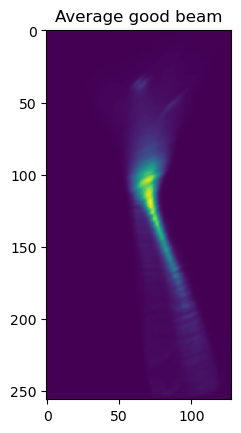

In [183]:
rep_good_beam = np.mean([rho_test[ind,0] for ind in ace_idx], axis = 0)
plt.imshow(rep_good_beam)
plt.title("Average good beam")

## The worst performers

In [219]:
failure_idx = np.where(test_performance > 0.065)[0];
print(f"There are {len(failure_idx)} test cases on which performance was worse than average")

There are 90 test cases on which performance was worse than average


In [220]:

rho_failures = [rho_test[i] for i in failure_idx]

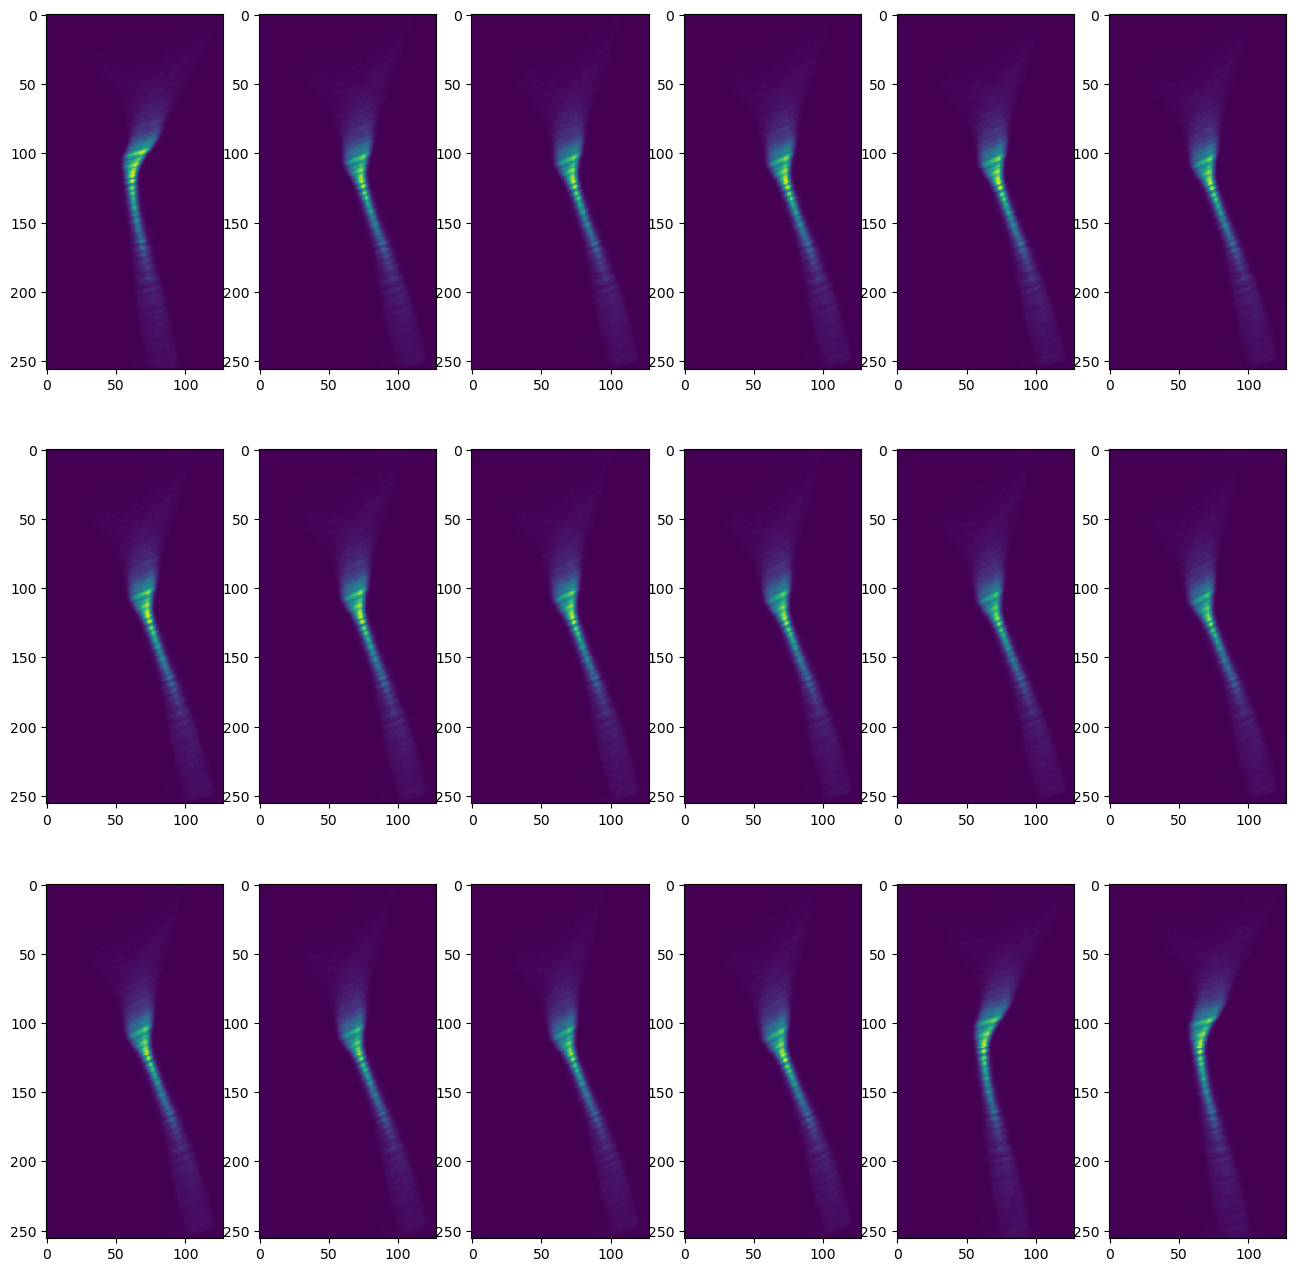

In [221]:


fig, ax = plt.subplots(3,6, figsize = (16, 16))

for i in range(3):
    for j in range(6):
        rho = rho_failures[3*i + j]
        ax[i][j].imshow(rho[0,:,:])

Max Ws amplitude is 0.44741103053092957
Max Wx amplitude is 0.3180985748767853
L_1-error is 22.511 pct
L_2-error is 6.207 pct


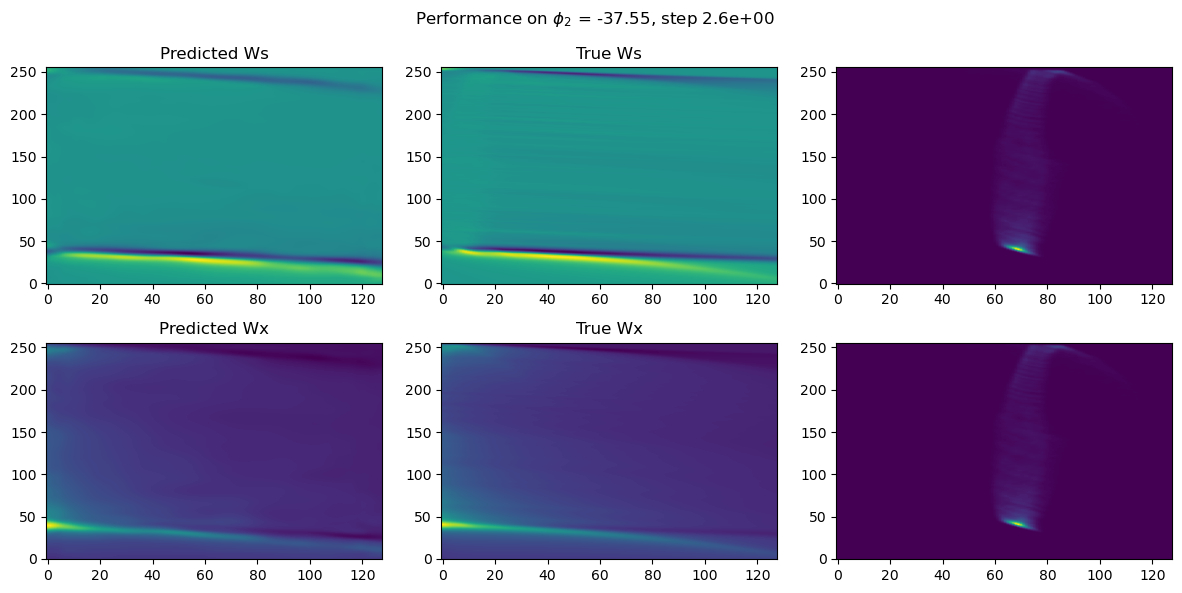

In [224]:
i = failure_idx[29]

fig, ax = plt.subplots(2,3,figsize=(12,6))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_test[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')


ax[0,1].imshow(W_test[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_test[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')
ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')

ax[0,2].imshow(rho_test[i,0], aspect='auto', origin='lower')
ax[1,2].imshow(rho_test[i,0], aspect='auto', origin='lower')

phi2 = phi_test[i];
s = s_data[i][0];
fig.suptitle(f"Performance on $\phi_2$ = {phi2}, step {s*20 :.1e}", fontsize=12)
fig.tight_layout()

err1 =  np.sqrt( (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( W_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( W_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {100*err1/reff_amp_s:.3f} pct")
print(f"L_2-error is {100*err2/reff_amp_s:.3f} pct")

Text(0.5, 1.0, 'Average bad beam')

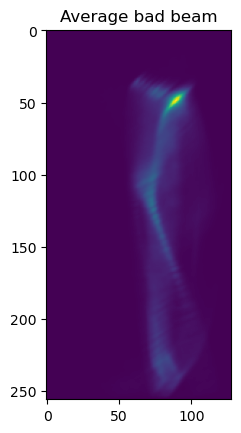

In [191]:
rep_bad_beam = np.mean([rho_test[ind,0] for ind in failure_idx], axis = 0)
plt.imshow(rep_bad_beam)
plt.title("Average bad beam")

In [ ]:
plt.hist(100*test_rel_performance, 30, color = 'salmon');
plt.xlabel("L1 Loss on Wakes (pct)");
plt.ylabel("Counts");

## Save these weights somewhere safe

In [ ]:
torch.save(csr2d_model.state_dict(), 'good_state_' + today + '__750_epochs')
print("Saved our weights")

In [ ]:
csr2d_model.eval();

In [ ]:
i%20

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
i = ace_idx[20]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(128)
y = np.arange(256)
X, Y = np.meshgrid(x, y)
Z1 = Ws_norm * result_test[i,1].cpu().detach().numpy()/1e6

ax.plot_surface(X, Y, Z1, cmap=plt.cm.hot, alpha=1, rstride=1, cstride=1)
ax.view_init(20, -30)
ax.set_xlabel('x (a.u.)')
ax.set_ylabel('z (a.u.)')
ax.set_zlabel('Ws (MV)')
plt.savefig('04-30-2024_750_epochs_WxPred_P2_-38.975_step_4.png')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(128)
y = np.arange(256)
X, Y = np.meshgrid(x, y)
Z2 =  W_test[i,1]
ax.plot_surface(X, Y, Z2, cmap=plt.cm.winter, alpha=1, rstride=1, cstride=1)
ax.view_init(20, -30)
ax.set_xlabel('x (a.u.)')
ax.set_ylabel('z (a.u.)')
ax.set_zlabel('Ws (MV)')
plt.savefig('04-30-2024_750_epochs_WxOG_P2_-38.975_step_4.png')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(128)
y = np.arange(256)
X, Y = np.meshgrid(x, y)
Z3=  abs(Z2 - Z1)
ax.plot_surface(X, Y, Z3, cmap=plt.cm.winter, alpha=1, rstride=1, cstride=1)
ax.view_init(20, -30)

## Check wake s dependence

In [ ]:
def load_step_s_check(file, directory = '/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/', emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');

    result = h5['csr_result'];
    
    #print(result.keys())
    nz, nx = np.array(result["Ws_grid"]).T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = np.array(result["lambda_grid"]).T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = min(result["zmin"]); ## minimum z coordinate
    zmax = max(result["zmin"]);
    xmin = min(result["xv"]);
    xmax = max(result["xv"]);

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = np.array(result["Ws_grid"]).T;
    Wx_grid = np.array(result["Wx_grid"]).T;
    lambda_grid = np.array(result["lambda_grid"]).T;
        
    return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;

In [ ]:
counter = 0
for j, file in enumerate(os.listdir('/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/')):
    #if j % 6 == 0:
    #    print(j)
    if file.startswith('result_P1_-20_P2_-38.35_'):
        print(file)
        xv, zv, Ws, Wx, rho, s = load_step_s_check(file)
        Ws = Ws[:-1,:-1]
        Wx = Wx[:-1,:-1]
        rho = rho[:]

        dx = np.mean(np.diff(xv))
        dz = np.mean(np.diff(zv))

        s = float(file[-6:-3])

        if (counter == 0):
            Ws_data_s_check = [Ws]
            Wx_data_s_check = [Wx]
            rho_data_s_check = [rho*dx*dz] ## note: rho is normalized to have sum of unity 
            dx_data_s_check = [dx]
            dz_data_s_check = [dz]
            s_data_s_check = [s]
        else:
            Ws_data_s_check = np.concatenate(([Ws], Ws_data_s_check))
            Wx_data_s_check = np.concatenate(([Wx], Wx_data_s_check))
            rho_data_s_check = np.concatenate(([rho*dx*dz], rho_data_s_check)) ## note: rho is normalized to have sum of unity 
            dx_data_s_check = np.concatenate(([dx], dx_data_s_check))
            dz_data_s_check = np.concatenate(([dz], dz_data_s_check))
            s_data_s_check = np.concatenate(([s], s_data_s_check))

        counter += 1

In [ ]:
Wx_data_s_check.shape

idx = np.argsort(s_data_s_check)
Ws_data_s_check = Ws_data_s_check[idx]
Wx_data_s_check = Wx_data_s_check[idx]
s_data_s_check = s_data_s_check[idx]
dx_data_s_check = dx_data_s_check[idx]
dz_data_s_check = dz_data_s_check[idx]

In [ ]:
### NOTE: resize_transform does not preserve the sum of the arrays over the grid. Thus we multiply by (100*200/(256*128))                
## when we resize back later on, we should multiply by the inverse factor 

Ws_data_s_check = torch.tensor(Ws_data_s_check)
Ws_data_s_check = (100*200/(256*128))*resize_transform(Ws_data_s_check)
Ws_data_s_check = torch.unsqueeze(Ws_data_s_check, dim=1)

Wx_data_s_check = torch.tensor(Wx_data_s_check)
Wx_data_s_check = (100*200/(256*128))*resize_transform(Wx_data_s_check)
Wx_data_s_check = torch.unsqueeze(Wx_data_s_check, dim=1)

rho_data_s_check = torch.tensor(rho_data_s_check)
rho_data_s_check = (100*200/(256*128))*resize_transform(rho_data_s_check)
rho_data_s_check = torch.unsqueeze(rho_data_s_check, dim=1)

dx_data_s_check = torch.tensor(dx_data_s_check)
dx_data_s_check = torch.unsqueeze(dx_data_s_check, dim=1)
dz_data_s_check = torch.tensor(dz_data_s_check)
dz_data_s_check = torch.unsqueeze(dz_data_s_check, dim=1)
s_data_s_check = torch.tensor(s_data_s_check)
s_data_s_check = torch.unsqueeze(s_data_s_check, dim=1)

#Ws_norm = torch.max(Ws_data_s_check)
#Wx_norm = torch.max(Wx_data_s_check)
#s_norm = torch.max(s_data_s_check)

Ws_data_s_check /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_data_s_check /= Wx_norm ## normalize to maximum Wx in dataset
s_data_s_check /= s_norm ## normalize to maximum s in dataset 
dz_data_s_check /= dz_norm 
dx_data_s_check /= dx_norm

In [ ]:
Ws_data_s_check = Ws_data_s_check.to(torch.float32)
Wx_data_s_check = Wx_data_s_check.to(torch.float32)
rho_data_s_check = rho_data_s_check.to(torch.float32)
s_data_s_check = s_data_s_check.to(torch.float32)
dz_data_s_check = dz_data_s_check.to(torch.float32)
dx_data_s_check = dx_data_s_check.to(torch.float32)

In [ ]:
## two-dimensional W array 
W_data_s_check = torch.cat((Ws_data_s_check, Wx_data_s_check), dim=1)
scalar_data_s_check = torch.cat((s_data_s_check, dz_data_s_check, dx_data_s_check), dim=1)

In [ ]:
output_s_check =csr2d_model([rho_data_s_check.to(curr_device), scalar_data_s_check.to(curr_device)])

In [ ]:

fig, ax = plt.subplots(2,11,figsize=(15,4), sharey=True)

for i in range(W_data_s_check.size(0)):
    ax[0,i].imshow(W_data_s_check[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[1,i].imshow(output_s_check[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[0,i].set_title(f's={s_data_s_check[i].detach().numpy().mean()*s_norm:.2f} m')
ax[0,0].set_ylabel('True Ws')
ax[1,0].set_ylabel('Predicted Ws')

In [ ]:
### fig, ax = plt.subplots(2,11,figsize=(15,4), sharey=True)

for i in range(W_data_s_check.size(0)):
    ax[0,i].imshow(W_data_s_check[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[1,i].imshow(output_s_check[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[0,i].set_title(f's={s_data_s_check[i].detach().numpy().mean()*s_norm:.2f} m')
ax[0,0].set_ylabel('True Wx')
ax[1,0].set_ylabel('Predicted Wx')
plt.show()

# Reasonable version 04/30/2024

In [ ]:
#torch.save(csr2d_model.state_dict(), 'good_state_April202024')

In [ ]:
class CSR2D(nn.Module):
    def __init__(self):
        super(CSR2D, self).__init__()

        encoding_dim = 16 # length of 1D beam density image representation
        
        num_conv = 5 # number of convolutional layers in encoder
        nfilters = 32 # number of "matrices" in a single convolutional layer 
        kernel_sizes = (3, 7) # each size is the size of one side of the convolution matrix, we are applying two matrices here 
        pool_size = 2 # factor by which we reduce the image size on each conv layer 
        activation = nn.ReLU() # activation function for the conv layers
        
        encoder_layers = []
        
        for i in range(num_conv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0):
                    encoder_layers.append(nn.Conv2d(1, nfilters, kernel_size, padding=kernel_size//2))
                else:
                    encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding=kernel_size//2))
                encoder_layers.append(nn.BatchNorm2d(nfilters))
                encoder_layers.append(activation)
            #encoder_layers.append(nn.BatchNorm2d(nfilters))
            encoder_layers.append(nn.MaxPool2d(pool_size))
        
        encoder_layers.append(nn.Flatten())
        encoder_layers.append(nn.Linear(int(nfilters * 256/2**num_conv * 128/2**num_conv), encoding_dim))
        encoder_layers.append(activation)
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        num_dense = 2 # number of dense layers before the resizing dense layer  
        small_dim_power2 = 4 # size of image output from dense network is 2**(this) x 2**(this+1)
        num_units = 200 # number of nodes in intermediate dense layers 
        activation = nn.ReLU()
        
        dense_layers = []
        
        dense_layers.append(nn.Linear(encoding_dim + 3, num_units)) ## encoding_dim + number of scalar parameters 
        dense_layers.append(activation)
        
        for _ in range(num_dense - 1):
            dense_layers.append(nn.Linear(num_units, num_units))
            dense_layers.append(activation)
        
        dense_layers.append(nn.Linear(num_units, 2**(2*small_dim_power2+1)))
        dense_layers.append(activation)
        dense_layers.append(nn.Unflatten(1, (1,2*2**small_dim_power2, 2**small_dim_power2) )   );

        self.intermediate = nn.Sequential(*dense_layers)
        
        decoder_layers = []
        num_deconv = 7 - small_dim_power2
        
        nfilters = 32
        kernel_sizes = [3, 7]
        pool_size = 2
        activation = nn.ReLU()
        
        for i in range(num_deconv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0): 
                    decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                else:
                    decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                decoder_layers.append(nn.BatchNorm2d(nfilters))
                decoder_layers.append(activation)
            #decoder_layers.append(nn.BatchNorm2d(nfilters))
            decoder_layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
        
        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size=1, padding=0)) # linear activation is necessary if our network needs to give negative numbers
        
        self.decoder = nn.Sequential(*decoder_layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, img_inputs):
        scalar_inputs = img_inputs[1]
        img_inputs = img_inputs[0]
        encoded_flattened = self.encoder(img_inputs)
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        afterNN = self.intermediate(concatenated)
        decoded = self.decoder(afterNN) # Reshape to match the input size of decoder
        return decoded

In [ ]:
"global/homes/o/ocamacho/2DCSR_from_home/Modify network inputs and loss function/good_state_04-30-2024__750_epochs"

In [ ]:
csr2d_model = CSR2D()
csr2d_model.to(curr_device)
weights_loc = "global/homes/o/ocamacho/2DCSR_from_home/Modify network inputs and loss function/normalization_04-30-24_750_epochs.txt"#"global/homes/o/ocamacho/2DCSR_from_home/Modify network inputs and loss function/good_state_04-30-2024__750_epochs"
import os
cwd = os.getcwd()

camin = cwd + "/good_state_04-30-2024__750_epochs";

basedir = '/global/u1/r/riverr/2DCSR/Modify network inputs and loss function/'
basedir = "global/u1/ocamacho/2DCSR_from_home/Modify network inputs and loss function/good_state_04-30-2024__750_epochs/"
csr2d_model.load_state_dict(torch.load(camin,  map_location=torch.device('cpu')))#, map_location='cpu', weights_only=True))

In [ ]:
L2_phases = []
for j, file in enumerate(os.listdir(tracking_results_direc)):
    if file.startswith('result'):
        ind_0 = file.find("P2");
        ind_1 = file.find(".h");
        L2_phase = file[ind_0+3: ind_1];
        L2_phases.append(float(L2_phase));
L2_phases.sort()

excluded_phases = [L2_phases[i] for i in range(0,2)];
excluded_phases += ([L2_phases[i] for i in range(-2,0)]);   
excluded_phases;
print("Excluding phases ");
for phi in excluded_phases:
    print(phi, ",");
print(" from training")

In [ ]:
%%time
allData =  load_data(tracking_results_direc, excluded_phases)
dataDict = allData['train'];
testDict = allData['test'];
Ws_data, Wx_data, rho_data, dz_data, dx_data, s_data, phi_data = dataDict['Ws'], dataDict['Wx'], dataDict['rho'], dataDict['dz'], dataDict['dx'], dataDict['s'], dataDict['phi2']
Ws_test, Wx_test, rho_test, dz_test, dx_test, s_test, phi_test = testDict['Ws'], testDict['Wx'], testDict['rho'], testDict['dz'], testDict['dx'], testDict['s'], testDict['phi2']

print("Data successfully loaded")

In [ ]:
with h5py.File(cwd + '/norms_04-30-2024__750_epochs.h5', 'r') as f:
    Ws_norm = np.array(f['Ws_norm'])
    Wx_norm = np.array(f['Wx_norm'])
    dx_norm = np.array(f['dx_norm'])
    dz_norm = np.array(f['dz_norm'])
    s_norm = np.array(f['s_norm'])

In [ ]:
fac = 100*200/(256*128);

Ws_data = torch.tensor(Ws_data)
Ws_data = fac*resize_transform(Ws_data)
Ws_data = torch.unsqueeze(Ws_data, dim=1)

Wx_data = torch.tensor(Wx_data)
Wx_data = fac*resize_transform(Wx_data)
Wx_data = torch.unsqueeze(Wx_data, dim=1)

rho_data = torch.tensor(rho_data)
rho_data = fac*resize_transform(rho_data)
rho_data = torch.unsqueeze(rho_data, dim=1)

dx_data = torch.tensor(dx_data)
dx_data = torch.unsqueeze(dx_data, dim=1)
dz_data = torch.tensor(dz_data)
dz_data = torch.unsqueeze(dz_data, dim=1)
s_data = torch.tensor(s_data)
s_data = torch.unsqueeze(s_data, dim=1)

#Ws_norm = torch.max(Ws_data)
#Wx_norm = torch.max(Wx_data)


Ws_data /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_data /= Wx_norm ## normalize to maximum Wx in dataset
s_data /= s_norm ## normalize to maximum s in dataset 
dz_data /= dz_norm ## normalize dz to maximum dz in dataset 
dx_data /= dx_norm





Ws_data = Ws_data.to(torch.float32)
Wx_data = Wx_data.to(torch.float32)
rho_data = rho_data.to(torch.float32)
s_data = s_data.to(torch.float32)
dz_data = dz_data.to(torch.float32)
dx_data = dx_data.to(torch.float32)



## two-dimensional W array 
W_data = torch.cat((Ws_data, Wx_data), dim=1);
scalar_data = torch.cat((s_data,dx_data,dz_data), dim=1);


print("Training data loaded and processed")





fac = 100*200/(256*128);

Ws_test = torch.tensor(Ws_test)
Ws_test = fac*resize_transform(Ws_test)
Ws_test = torch.unsqueeze(Ws_test, dim=1)

Wx_test = torch.tensor(Wx_test)
Wx_test = fac*resize_transform(Wx_test)
Wx_test = torch.unsqueeze(Wx_test, dim=1)

rho_test = torch.tensor(rho_test)
rho_test = fac*resize_transform(rho_test)
rho_test = torch.unsqueeze(rho_test, dim=1)

dx_test = torch.tensor(dx_test)
dx_test = torch.unsqueeze(dx_test, dim=1)

dz_test = torch.tensor(dz_test)
dz_test = torch.unsqueeze(dz_test, dim=1)

s_test = torch.tensor(s_test)
s_test = torch.unsqueeze(s_test, dim=1)



Ws_test /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_test /= Wx_norm ## normalize to maximum Wx in dataset
s_test /= s_norm ## normalize to maximum s in dataset 
dz_test /= dz_norm ## normalize dz to maximum dz in dataset 
dx_test /= dx_norm



Ws_test = Ws_test.to(torch.float32)
Wx_test = Wx_test.to(torch.float32)
rho_test = rho_test.to(torch.float32)
s_test = s_test.to(torch.float32)
dz_test = dz_test.to(torch.float32)
dx_test = dx_test.to(torch.float32)



## two-dimensional W array 
W_test = torch.cat((Ws_test, Wx_test), dim=1);
scalar_test = torch.cat((s_test,dx_test,dz_test), dim=1);


print("Test data loaded and processed")

In [ ]:
plt.imshow(rho_data.detach().numpy()[0][0], aspect='auto')
plt.colorbar()

In [ ]:
scalars = torch.cat((s_data,dx_data,dz_data),dim=1)

In [ ]:
rho_data = rho_data.to(torch.float32)
scalars = scalars.to(torch.float32)

In [ ]:
Ws_norm.mean()

In [ ]:
csr2d_model.eval()
out = csr2d_model([rho_test.to(curr_device), scalar_test.to(curr_device)]);
out[:,0,:,:] *= Ws_norm.mean()
out[:,1,:,:] *= Wx_norm.mean()
resized_out = 128*256 / (101*201) * inverse_resize_transform(out)

In [ ]:
out.shape

In [ ]:
out.cpu().detach().numpy().shape

In [ ]:
t = 77

Ws = resized_out.cpu().detach().numpy()[t,0]
Wx = resized_out.cpu().detach().numpy()[t,1]

In [ ]:
plt.imshow(rho_test[t,0])

In [ ]:
plt.imshow(Ws)
plt.show()
plt.imshow(Wx)